**Author:** Boris Kundu

**Problem Statement:** Comparing different RNN models on Time-Series data

**Dataset:** COVID-19 hospitalizations

In [320]:
#Import packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [321]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [322]:
#Standardize data
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

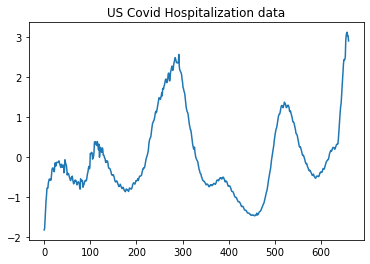

In [323]:
#Plot data
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [324]:
#Parameters
last = len(hosp) #Total data points
seqlen = 20 # Input size or window size
batchsize = 50 # Data period and number of data points
trainbegin = np.random.randint(400) #Get random start day for training

In [325]:
#Preparing training data
Xtrain = np.array(hosp[trainbegin:trainbegin+seqlen])
ytrain = np.array(hosp[trainbegin+seqlen])
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [326]:
#Create tensors
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)

In [327]:
#Input parameters
inputsize = 1
hiddensize = 10
outputsize = 1
epochs = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [328]:
#Elman RNNCell optimized with Adam
class RNNCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNNCell, self).__init__()
        self.rnn = nn.RNNCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [329]:
#Initialize model
rnnc = RNNCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_rnnc = optim.Adam(rnnc.parameters())

In [330]:
#Training model
def Train(model,epoch,optimizr,subject):
    for i in range(epoch):
        yhat = model(X2)
        L = F.mse_loss(yhat, y)
        if(i%100 == 0):
            print(f'{subject} Epoch:{i+1} with Loss:{L.item()}')
        optimizr.zero_grad()
        L.backward()
        optimizr.step()

In [331]:
#Train RNNCell
Train(rnnc,epochs,optimizer_rnnc,'RNNCell')

RNNCell Epoch:1 with Loss:0.22936491668224335
RNNCell Epoch:101 with Loss:0.010107369162142277
RNNCell Epoch:201 with Loss:0.0037844509351998568
RNNCell Epoch:301 with Loss:0.002124408958479762
RNNCell Epoch:401 with Loss:0.0015000428538769484
RNNCell Epoch:501 with Loss:0.001225793268531561
RNNCell Epoch:601 with Loss:0.001085797674022615
RNNCell Epoch:701 with Loss:0.0010427626548334956
RNNCell Epoch:801 with Loss:0.0009458607528358698
RNNCell Epoch:901 with Loss:0.0009247572743333876


In [332]:
#Training Plot
def plotTrain(subject):
    plt.plot(y.detach().numpy())
    plt.plot(yhat.detach().numpy())
    plt.legend(['True','Predicted'])
    plt.title(f'{subject} - Training started at {str(trainbegin)}')
    plt.show()

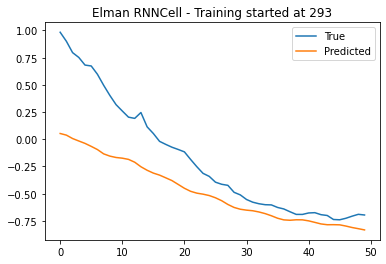

In [333]:
#Plot Elman RNNCell
plotTrain('Elman RNNCell')

In [334]:
#Deep 2-layer RNN model
class RNN(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(inputsize,hiddensize,2) #2-layer RNN
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn (2, batchsize , hiddensize)
        output, _ = self.rnn (X2,hx)
        return self.layer2(output[seqlen - 1])[:, 0]

In [335]:
#Define model
rnn = RNN(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_rnn = optim.Adam(rnn.parameters())

In [336]:
#Train deep 2-layer RNN
Train(rnn,epochs,optimizer_rnn,'RNN')

RNN Epoch:1 with Loss:0.8508228063583374
RNN Epoch:101 with Loss:0.008412417024374008
RNN Epoch:201 with Loss:0.002134858164936304
RNN Epoch:301 with Loss:0.0016799344448372722
RNN Epoch:401 with Loss:0.0014929819153621793
RNN Epoch:501 with Loss:0.0013973750174045563
RNN Epoch:601 with Loss:0.0013368470827117562
RNN Epoch:701 with Loss:0.0012891893275082111
RNN Epoch:801 with Loss:0.0012466557091102004
RNN Epoch:901 with Loss:0.001205701264552772


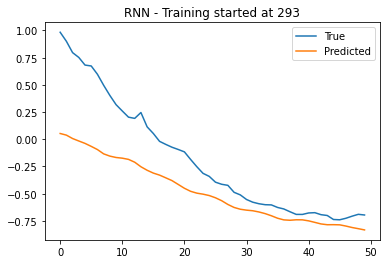

In [337]:
#Plot RNN
plotTrain('RNN')

In [338]:
#nn.Linear model
class Linear(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(Linear, self).__init__()
        self.rnn = nn.Linear(inputsize + hiddensize , hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = torch.tanh(self.rnn(torch.cat((X2[i],hx),1)))
        return self.layer2(hx)[:, 0]

In [339]:
#Define model
lin = Linear(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lin = optim.Adam(lin.parameters())

In [340]:
#Train Linear
Train(lin,epochs,optimizer_lin,'Linear')

Linear Epoch:1 with Loss:0.5161821842193604
Linear Epoch:101 with Loss:0.14850351214408875
Linear Epoch:201 with Loss:0.013303832150995731
Linear Epoch:301 with Loss:0.006844107992947102
Linear Epoch:401 with Loss:0.004321676678955555
Linear Epoch:501 with Loss:0.0030625122599303722
Linear Epoch:601 with Loss:0.002433737274259329
Linear Epoch:701 with Loss:0.0021184757351875305
Linear Epoch:801 with Loss:0.0019254200160503387
Linear Epoch:901 with Loss:0.0018165558576583862


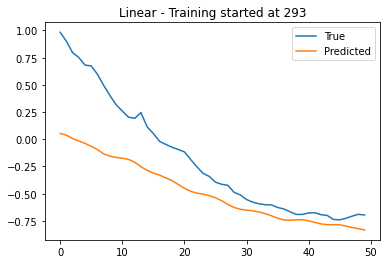

In [341]:
#Plot Linear
plotTrain('Linear')